# Sparkify Project !

Customer engagement and churn have always been crucial subjects for businesses. Predictive analysis helps businesses to take proactive actions such as offers and discounts to retain their customers and in some cases improve loyalty. As nowadays we produce an incredible amount of data which can be used for such analysis, data science has gained great importance for companies.

In [ ]:
# this cell is for me to import and read file from IBM Cloud Storage
# if you want a method on how to connect local pyspark please check cell below
import ibmos2spark, os

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint = ''
else:
    endpoint = ''

credentials = {
    'endpoint': endpoint,
    'service_id': '',
    'iam_service_endpoint': '',
    'api_key': ''
}

configuration_name = ''
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.read.json(cos.url('mini_sparkify_event_data.json', 'sparkify03-donotdelete-pr-lnug509ze2bgb5'))
df.take(5)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210921140406-0002
KERNEL_ID = 59bb4f2a-8c0e-47d5-bfdd-ac4f494bdb79


[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [ ]:
'''
in case you use local PySpark

spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

'''

# Import and Define Function

In [ ]:
import os
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler

sns.set(style="darkgrid")
%matplotlib inline

In [ ]:
def create_churn_label(df):
    
    '''
    INPUT:
    df - (Spark DataFrame) df as defined at the top of the notebook 
    
    OUTPUT:
    churn_df - (Spark DataFrame) df with churn label column
    
    DESCRIPTION:
    - create churn label column
    '''
    
    churn = df.withColumn('churn',when((col('page').isin(['Cancellation Confirmation','Cancel'])) | (col('auth')=='Cancelled'),1 ).otherwise(0))\
    .groupby('userId').agg(sum('churn').alias('churn')).withColumn('churn', when(col('churn')>=1 ,1).otherwise(0))

    churn_df = df.join(churn, on='userId')

    return churn_df

In [ ]:
def clean_data(df):
    
    '''
    INPUT:
    df - (Spark DataFrame) [churn_df]
    
    OUTPUT:
    new_df - (Spark DataFrame) df that cleaned and ready for EDA & Feature Engineering
    
    DESCRIPTION:
    - casts unixtimestamp into datetime type
    - creates month and date columns
    - casts userId column into long type
    - drops missing value
    - cleanse userAgent and location columnns
    '''
    
    new_df = df.filter(col('userId').isNotNull())
    new_df = new_df.filter((col('auth')!='Logged Out') & (col('auth')!='Guest'))
    new_df = new_df.withColumn('timeStamp', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    new_df = new_df.withColumn('month', month(col('timeStamp')))
    new_df = new_df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    new_df = new_df.withColumn('userId', col('userId').cast(LongType()))
    new_df = new_df.withColumn('userAgent', regexp_extract('userAgent', 'Macintosh|Windows|iPad|X11|iPhone', 0))
    cleaned_df = new_df.withColumn('location', split(col('location'),',').getItem(1))
    
    return cleaned_df

In [ ]:
def create_nonpage_features(df):
    
    '''
    INPUT:
    df - (Spark DataFrame) [cleaned_df]

    OUTPUT:
    nonpage_df - (Spark DataFrame) df with non-page feature columns

    DESCRIPTION:
    - creates lastinteraction, account level, and average length columns
    '''
    
    last_interaction =  df.groupBy('userId').agg(max('ts').alias('last_interaction'))
    acc_level = df.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('acc_level'))
    avg_length = df.groupBy('userId').avg('length').withColumnRenamed('avg(length)', 'avg_length')

    new_df = df.drop('level')
    new_df = new_df.drop('length')
    new_df = last_interaction.join(new_df, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))
    
    nonpage_df = new_df.join(acc_level, on='userId').join(avg_length, on='userId')
    nonpage_df = nonpage_df.drop('artist','auth','firstName','gender','itemInSession','lastName','location','method','page'\
                                 ,'registration','sessionId','song','status','ts','userAgent','churn','timeStamp','month','date')
    
    return nonpage_df

In [ ]:
def create_page_features(df):
    
    '''
    INPUT:
    df - (Spark DataFrame) [cleaned_df]
    
    OUTPUT:
    page_df - (Spark DataFrame) df with page features columns
    
    DESCRIPTION:
    - group all unique pages with daily and monthly timeframe 
    to create average page visit in a specific timeframe
    '''

    new_df = df.where((col("page") != "Cancel") & (col("page") != "CancelletionConfirmation"))
    distinct_list = [row.page for row in new_df.select('page').distinct().collect()]
    
    page_dict={}
    for page in distinct_list:
        page_dict.update({page:'mean'})
        
    #----------------------------------------------------------------------------------------------------------------------
        
    daily_page_event = new_df.groupby('userId','date').pivot('page').count()
    daily_page_event = daily_page_event.join(daily_page_event.groupBy('userId').agg(page_dict).fillna(0), on='userId')

    for page in distinct_list:
        daily_page_event = daily_page_event.drop(page)  
        daily_page_event = daily_page_event.withColumnRenamed('avg({})'.format(page), 'daily_avg_{}'.format(page))

    daily_page_event = daily_page_event.drop('date')
    daily_page_event = daily_page_event.drop_duplicates()
    
    #-----------------------------------------------------------------------------------------------------------------------
    
    monthly_page_event = new_df.groupby('userId','month').pivot('page').count()
    monthly_page_event = monthly_page_event.join(monthly_page_event.groupBy('userId').agg(page_dict).fillna(0), on='userId')

    for page in distinct_list:
        monthly_page_event = monthly_page_event.drop(page)    
        monthly_page_event = monthly_page_event.withColumnRenamed('avg({})'.format(page), 'monthly_avg_{}'.format(page))

    monthly_page_event = monthly_page_event.drop('month').drop_duplicates()
    monthly_page_event = monthly_page_event.drop_duplicates()
    
    #-----------------------------------------------------------------------------------------------------------------------
    
    page_df = daily_page_event.join(monthly_page_event, on='userId')

    return page_df

In [ ]:
def create_session_features(df):
    
    '''
    INPUT:
    df - (Spark DataFrame) [cleaned_df]
    
    OUTPUT:
    session_df - (Spark DataFrame) df with session feature columns
    
    DESCRIPTION:
    - group session duration and session count with daily and monthly timeframe
    to create average session statistic in each time frame
    '''
    
    daily_avg_count = df.groupby('userId','date').agg(countDistinct('sessionId')).groupBy('userId')\
    .avg('count(DISTINCT sessionId)').withColumnRenamed('avg(count(DISTINCT sessionId))', 'daily_avg_sessions_count')
    
    monthly_avg_count = df.groupby('userId','month').agg(countDistinct('sessionId')).groupBy('userId')\
    .avg('count(DISTINCT sessionId)').withColumnRenamed('avg(count(DISTINCT sessionId))', 'monthly_avg_sessions_count')
    
    daily_avg_duration = df.groupby('userId','date','sessionId').agg(max('ts').alias('session_end'), min('ts').alias('session_start'))\
    .withColumn('session_duration_sec', (col('session_end')-col('session_start'))/1000).groupby('userId','date').avg('session_duration_sec')\
    .groupby('userId').agg(mean('avg(session_duration_sec)').alias('daily_avg_sessions_duration')).orderBy('userId', ascending=False)
    
    monthly_avg_duration = df.groupby('userId','month','sessionId').agg(max('ts').alias('session_end'), min('ts').alias('session_start'))\
    .withColumn('session_duration_sec', (col('session_end')-col('session_start'))/1000).groupby('userId','month').avg('session_duration_sec')\
    .groupby('userId').agg(mean('avg(session_duration_sec)').alias('monthly_avg_sessions_duration')).orderBy('userId', ascending=False)
    
    daily_avg_item_count = df.groupby('userId','date').agg(max('itemInSession'))\
    .groupBy('userId').avg('max(itemInSession)').withColumnRenamed('avg(max(itemInSession))', 'daily_avg_sessions_items')
    
    monthly_avg_item_count = df.groupby('userId','month').agg(max('itemInSession'))\
    .groupBy('userId').avg('max(itemInSession)').withColumnRenamed('avg(max(itemInSession))', 'monthly_avg_sessions_items')
    
    #---------------------------------------------------------------------------------------------------------------------------------

    session_avg_count = daily_avg_count.join(monthly_avg_count, on='userId')
    session_avg_duration = daily_avg_duration.join(monthly_avg_duration, on='userId')
    session_avg_item_count = daily_avg_item_count.join(monthly_avg_item_count, on='userId')
    
    session_df = session_avg_count.join(session_avg_duration, on='userId').join(session_avg_item_count, on='userId')
    
    return session_df

In [ ]:
def features_combine(cleaned_df, nonpage_df, page_df, session_df):
    
    '''
    INPUT:
    cleaned_df - (Spark DataFrame)
    nonpage_df - (Spark DataFrame)
    page_df - (Spark DataFrame)
    session_df - (Spark DataFrame)
    
    OUTPUT:
    combined_df - (Spark DataFrame) df with every feature columns
    
    DESCRIPTION:
    - join all DataFrame aggregate features with userId column
    - drop duplicate row and UserId column
    '''
    
    new_df = cleaned_df.select('userId', 'churn', 'gender', 'location', 'userAgent')
    new_df = new_df.join(nonpage_df, on='userId')
    new_df = new_df.join(page_df, on='userId')
    new_df = new_df.join(session_df, on='userId')
    new_df = new_df.withColumnRenamed("churn", "label")
    
    combined_df = new_df.drop_duplicates()
    combined_df = combined_df.drop('userId')
    
    return combined_df

In [ ]:
def preprocess_data(df):
    
    '''
    INPUT:
    df - (Spark DataFrame) [combined_df]
    
    OUTPUT:
    feature_userAgent - (StringIndexer)
    feature_gender - (StringIndexer)
    feature_location - (StringIndexer)
    feature_acc_level - (StringIndexer)
    vector_assembler - (VectorAssembler)
    
    DESCRIPTION:
    - transform features with feature pipeline
    '''
    
    feature_userAgent = StringIndexer(inputCol='userAgent', outputCol='userAgent_index')
    feature_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
    feature_location = StringIndexer(inputCol='location', outputCol='location_index')
    feature_acc_level = StringIndexer(inputCol='acc_level', outputCol='acc_level_index')
    print('StringIndexer Created')
    print('...')

    double_long_columns = []
    for field in df.schema.fields :
        if field.dataType != StringType():
            double_long_columns.append(field.name)
    double_long_columns.remove('label')
    double_long_columns.append('userAgent_index')
    double_long_columns.append('gender_index')
    double_long_columns.append('location_index')
    double_long_columns.append('acc_level_index')
    print(double_long_columns, "CHECKED")
    print('...')
    
    vector_assembler = VectorAssembler(inputCols=double_long_columns, outputCol='features')
    process_pipeline = Pipeline(stages=[feature_userAgent, feature_gender, feature_location, feature_acc_level, vector_assembler])
    preprocessed_df = process_pipeline.fit(df).transform(df)
    
    return preprocessed_df

In [ ]:
def train_models(train, test, valid, ml):

    '''
    INPUT:
    train - (Spark DataFrame)
    test - (Spark DataFrame)
    valid - (Spark DataFrame)
    ml - (Pyspark ML)
    
    OUTPUT:
    model - (Pyspark ML) trained model
    pred_train - (Spark DataFrame) prediction on train dataset
    pred_test - (Spark DataFrame) prediction on test dataset
    pred_valid - (Spark DataFrame) prediction on valid dataset
    
    DESCRIPTION:
    - fits and runs predictions with given train, test, valid data
    - displays results for given model
    
    '''
    
    print('Training model')
    print('...')
    model = ml.fit(train)
        
    evaluator = MulticlassClassificationEvaluator(labelCol='label')
    pred_train = model.transform(train)
    pred_test = model.transform(test)
    pred_valid = model.transform(valid)

    print('Metrics:')
    print('...')
    print('Train - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_train, {evaluator.metricName: "accuracy"}), 100*evaluator.evaluate(pred_train, {evaluator.metricName: "f1"})))
    print('Test  - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_test, {evaluator.metricName: "accuracy"}), 100*evaluator.evaluate(pred_test, {evaluator.metricName: "f1"})))
    print('Valid - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_valid, {evaluator.metricName: "accuracy"}), 100*evaluator.evaluate(pred_valid, {evaluator.metricName: "f1"})))
        
    return model, pred_train, pred_test, pred_valid

In [ ]:
def tune_models(train, test, valid, ml):

    '''
    INPUT:
    train - (Spark DataFrame)
    test - (Spark DataFrame)
    valid - (Spark DataFrame)
    ml - (String) choose either one of this ['Logistic Regression', 'Random Forest Classifier', 'Gradient Boosted Tree', 'Naive Bayes']
    
    OUTPUT:
    model - (Pyspark ML) tuned model
    pred_train - (Spark DataFrame) prediction on train dataset
    pred_test - (Spark DataFrame) prediction on test dataset
    pred_valid - (Spark DataFrame) prediction on valid dataset
    
    DESCRIPTION:
    - fits and runs predictions with given train, test, valid data
    - tune chosen machine learning model
    - displays results for given model
    '''
    
    models = {
        'Logistic Regression': LogisticRegression(maxIter=10, labelCol="label"),
        'Random Forest Classifier': RandomForestClassifier(labelCol="label"),
        'Gradient Boosted Tree': GBTClassifier(maxIter=10, labelCol="label"),
        'Naive Bayes': NaiveBayes(labelCol="label")
    }
    
    paramGrid = {
        'Logistic Regression': ParamGridBuilder()\
            .addGrid(models['Logistic Regression'].regParam, [0.01,0.001])\
            .addGrid(models['Logistic Regression'].family, ['binomial','multinomial'])\
            .build(),
        'Random Forest Classifier': ParamGridBuilder()\
            .addGrid(models['Random Forest Classifier'].numTrees, [30, 60])\
            .addGrid(models['Random Forest Classifier'].maxDepth, [10, 30])\
            .build(),
        'Gradient Boosted Tree': ParamGridBuilder()\
            .addGrid(models['Gradient Boosted Tree'].maxBins, [40, 100])\
            .addGrid(models['Gradient Boosted Tree'].maxDepth, [10, 30])\
            .build(),
        'Naive Bayes': ParamGridBuilder()\
            .addGrid(models['Naive Bayes'].smoothing, [0.5,0.8])\
            .build()
    }
    
    print('Training model')
    print('...')
    pipeline = Pipeline(stages = [models[ml]])
    cv = CrossValidator(estimator = pipeline,
                        estimatorParamMaps = paramGrid[ml],
                        evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='f1'),
                        numFolds = 3)
    model = cv.fit(train)
        
    evaluator = MulticlassClassificationEvaluator(labelCol='label')
    pred_train = model.transform(train)
    pred_test = model.transform(test)
    pred_valid = model.transform(valid)
    print(ml + ' metrics:')
    print('...')
    print('Train - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_train, {evaluator.metricName: "accuracy"}), 100*evaluator.evaluate(pred_train, {evaluator.metricName: "f1"})))
    print('Test  - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_test, {evaluator.metricName: "accuracy"}), 100*evaluator.evaluate(pred_test, {evaluator.metricName: "f1"})))
    print('Valid - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_valid, {evaluator.metricName: "accuracy"}), 100*evaluator.evaluate(pred_valid, {evaluator.metricName: "f1"})))

    if ml == 'Random Forest Classifier':
        bestPipeline = model.bestModel
        for i in range(len(bestPipeline.stages[0].featureImportances)):
            print("{} : {} \n".format(preprocessed_df.columns[i], bestPipeline.stages[0].featureImportances[i]))
        print('Best parameters : [ max depth: {}, num Trees: {} ]'.format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getNumTrees))
        
    return model, pred_train, pred_test, pred_valid

# Exploratory Data Analysis

check dataframe size

In [ ]:
print((df.count(), len(df.columns)))

(286500, 18)


examine dataframe

In [ ]:
pd.DataFrame(df.take(20), columns=df.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


check all columns name and type

In [ ]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



count unique value

In [ ]:
df.select([countDistinct(x).alias(x) for x in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status|    ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+
| 17655|   4|      189|     2|         1322|     173| 14865|    2|     114|     2|  22|         225|     2354|58480|     3|277447|       56|   226|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+



check for missing value

In [ ]:
df.select([count(when(isnull(x), x)).alias(x) for x in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



check unique page column value

In [ ]:
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

check unique userAgent column value

In [ ]:
df.select('userAgent').distinct().collect()

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW6

count page column

In [ ]:
df.select('page').groupby('page').count().sort(col('count').desc()).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+
only showing top 20 rows



check unique auth column value

In [ ]:
df.select('auth').distinct().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Guest'),
 Row(auth='Logged In')]

count auth column

In [ ]:
df.select('auth').groupby('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



count auth and gender column

In [ ]:
df.select('userId','gender','auth').groupby(['gender','auth']).count().sort(col('count').desc()).show()

+------+----------+------+
|gender|      auth| count|
+------+----------+------+
|     F| Logged In|154558|
|     M| Logged In|123544|
|  null|Logged Out|  8249|
|  null|     Guest|    97|
|     M| Cancelled|    32|
|     F| Cancelled|    20|
+------+----------+------+



check unique location column value

In [ ]:
df.select('location').distinct().collect()

[Row(location='Atlantic City-Hammonton, NJ'),
 Row(location='Gainesville, FL'),
 Row(location='Deltona-Daytona Beach-Ormond Beach, FL'),
 Row(location='San Diego-Carlsbad, CA'),
 Row(location='Cleveland-Elyria, OH'),
 Row(location='Kingsport-Bristol-Bristol, TN-VA'),
 Row(location='New Haven-Milford, CT'),
 Row(location='Birmingham-Hoover, AL'),
 Row(location='Corpus Christi, TX'),
 Row(location='Dubuque, IA'),
 Row(location='Las Vegas-Henderson-Paradise, NV'),
 Row(location='Indianapolis-Carmel-Anderson, IN'),
 Row(location='Seattle-Tacoma-Bellevue, WA'),
 Row(location='Albany, OR'),
 Row(location='Winston-Salem, NC'),
 Row(location='Los Angeles-Long Beach-Anaheim, CA'),
 Row(location='Bakersfield, CA'),
 Row(location='Minneapolis-St. Paul-Bloomington, MN-WI'),
 Row(location='San Francisco-Oakland-Hayward, CA'),
 Row(location='Phoenix-Mesa-Scottsdale, AZ'),
 Row(location='Allentown-Bethlehem-Easton, PA-NJ'),
 Row(location='Miami-Fort Lauderdale-West Palm Beach, FL'),
 Row(location='Sa

check unique userAgent column value

In [ ]:
df.select('userAgent').distinct().collect()

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW6

check reference date of this dataframe

In [ ]:
df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType())).select(max('date'),min('date')).collect()

[Row(max(date)=datetime.date(2018, 12, 3), min(date)=datetime.date(2018, 10, 1))]

# EDA with Labeled DataFrame

In [ ]:
churn_df = create_churn_label(df)
cleaned_df = clean_data(churn_df)

In [ ]:
cleaned_df.select('userId','gender','churn').distinct().groupby('gender','churn').count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
+------+-----+-----+



In [ ]:
cleaned_df.select('userId','userAgent','churn').distinct().groupby('userAgent','churn').count().show()

+---------+-----+-----+
|userAgent|churn|count|
+---------+-----+-----+
|Macintosh|    0|   67|
|      X11|    0|    7|
|      X11|    1|    5|
|   iPhone|    1|    4|
|     iPad|    0|    3|
|Macintosh|    1|   19|
|  Windows|    0|   87|
|   iPhone|    0|    9|
|  Windows|    1|   24|
+---------+-----+-----+



In [ ]:
cleaned_df.select('userId','location','churn').distinct().groupby('location','churn').count().show()

+---------+-----+-----+
| location|churn|count|
+---------+-----+-----+
|       OK|    0|    1|
|    KY-IN|    0|    1|
|       MS|    1|    2|
|       WA|    0|    2|
|       MD|    0|    1|
|       CT|    0|    7|
|    GA-AL|    0|    2|
|       KY|    0|    1|
|       MT|    0|    1|
| IL-IN-WI|    0|    5|
|       PA|    0|    3|
|    UT-ID|    0|    1|
|       NY|    0|    4|
|       IN|    1|    1|
|       AR|    1|    1|
|       AL|    0|    2|
|       WA|    1|    2|
|       WV|    0|    1|
|       LA|    0|    1|
|    OR-WA|    0|    2|
+---------+-----+-----+
only showing top 20 rows



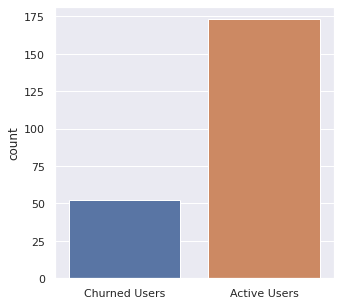

In [ ]:
churn_count = cleaned_df.select('userId','churn').distinct().groupby('churn').count().toPandas().sort_values(by='count')
churn_count.index = ["Churned Users", "Active Users"]
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
sns.barplot(churn_count.index, churn_count['count'], ax=ax)

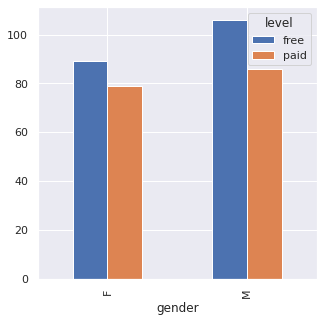

In [ ]:
gender_count = cleaned_df.select('userId','level','gender').distinct().groupby('level','gender').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
gender_count.pivot(index='gender', columns='level', values='count').plot(kind='bar', ax=ax)

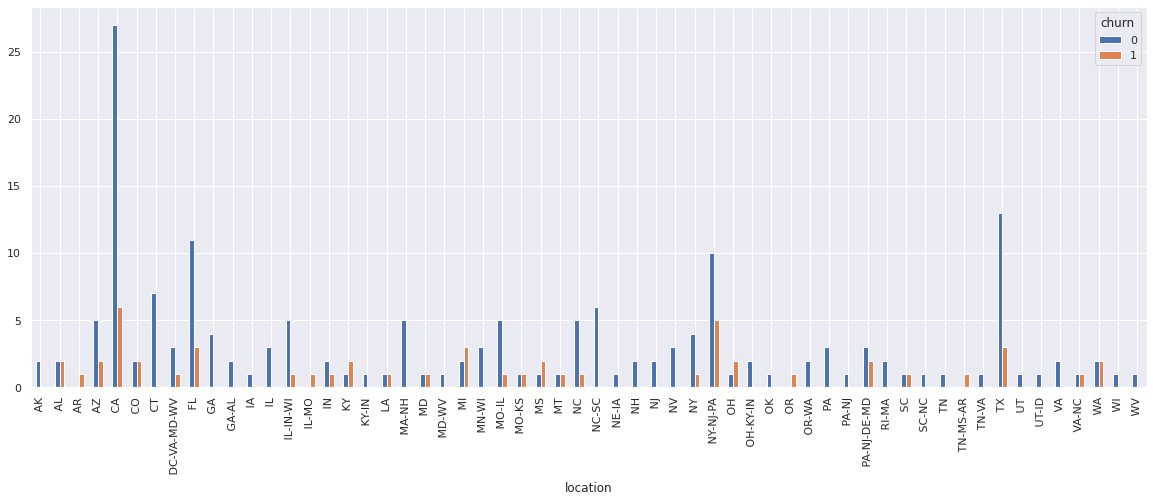

In [ ]:
location_count = cleaned_df.select('userId','location','churn').distinct().groupby('location','churn').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(20,7))
ax = fig.gca()
location_count.pivot(index='location', columns='churn', values='count').plot(kind='bar', ax=ax)

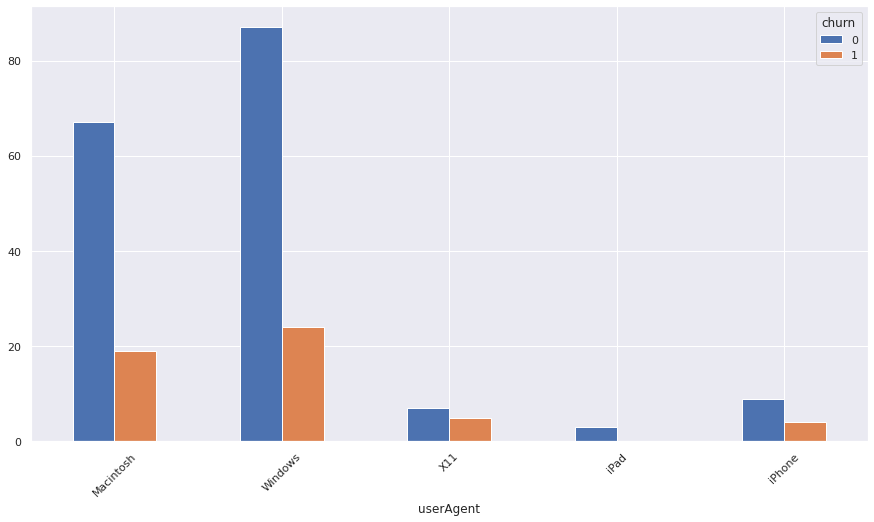

In [ ]:
userAgent_count = cleaned_df.select('userId','userAgent','churn').distinct().groupby('userAgent','churn').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
userAgent_count.pivot(index='userAgent', columns='churn', values='count').plot(kind='bar', ax=ax, rot=45)

# Features Selection

In [ ]:
churn_df = create_churn_label(df)
cleaned_df = clean_data(churn_df)
nonpage_df = create_nonpage_features(cleaned_df)
page_df = create_page_features(cleaned_df)
session_df = create_session_features(cleaned_df)

In [ ]:
combined_df = features_combine(cleaned_df, nonpage_df, page_df, session_df)
combined_df.printSchema()

root
 |-- label: integer (nullable = false)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- last_interaction: long (nullable = true)
 |-- registered_days: integer (nullable = true)
 |-- acc_level: string (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- daily_avg_Settings: double (nullable = false)
 |-- daily_avg_Add Friend: double (nullable = false)
 |-- daily_avg_Thumbs Down: double (nullable = false)
 |-- daily_avg_Downgrade: double (nullable = false)
 |-- daily_avg_Submit Upgrade: double (nullable = false)
 |-- daily_avg_Roll Advert: double (nullable = false)
 |-- daily_avg_NextSong: double (nullable = false)
 |-- daily_avg_Error: double (nullable = false)
 |-- daily_avg_About: double (nullable = false)
 |-- daily_avg_Upgrade: double (nullable = false)
 |-- daily_avg_Add to Playlist: double (nullable = false)
 |-- daily_avg_Home: double (nullable = false)
 |-- daily_avg_Thumbs Up: double (nul

In [ ]:
print((combined_df.count(), len(combined_df.columns)))

(225, 50)


In [ ]:
pd.DataFrame(combined_df.take(5), columns=combined_df.columns)

,label,gender,location,userAgent,last_interaction,registered_days,acc_level,avg_length,daily_avg_Settings,daily_avg_Add Friend,...,monthly_avg_Submit Downgrade,monthly_avg_Cancellation Confirmation,monthly_avg_Save Settings,monthly_avg_Help,daily_avg_sessions_count,monthly_avg_sessions_count,daily_avg_sessions_duration,monthly_avg_sessions_duration,daily_avg_sessions_items,monthly_avg_sessions_items
0,0,M,CA,Windows,1543515959000,77,free,255.828061,1.333333,1.500000,...,0.0,0.0,0.0,2.0,1.000000,4.0,11550.125000,11550.125000,42.625000,72.0
1,1,M,CA,Macintosh,1542181031000,60,paid,249.180173,1.266667,3.357143,...,0.0,1.0,4.0,14.0,1.517241,17.5,20307.833333,21214.731481,167.206897,575.5
2,0,M,NH,X11,1543490925000,71,paid,250.524328,1.642857,2.944444,...,0.0,0.0,3.5,6.5,1.125000,11.5,20399.291667,24605.900000,131.541667,301.5
3,0,M,MO-IL,X11,1543335647000,75,free,244.107080,1.000000,2.166667,...,1.0,0.0,0.0,3.0,1.000000,4.5,12687.100000,14584.850000,79.000000,225.0
4,1,M,IL-IN-WI,Macintosh,1541100900000,43,free,242.654103,0.000000,1.000000,...,1.0,1.0,0.0,2.0,1.142857,3.5,16226.500000,15400.333333,107.428571,144.5


In [ ]:
preprocessed_df = preprocess_data(combined_df)
preprocessed_df.printSchema()

StringIndexer Created
...
['last_interaction', 'registered_days', 'avg_length', 'daily_avg_Settings', 'daily_avg_Add Friend', 'daily_avg_Thumbs Down', 'daily_avg_Downgrade', 'daily_avg_Submit Upgrade', 'daily_avg_Roll Advert', 'daily_avg_NextSong', 'daily_avg_Error', 'daily_avg_About', 'daily_avg_Upgrade', 'daily_avg_Add to Playlist', 'daily_avg_Home', 'daily_avg_Thumbs Up', 'daily_avg_Logout', 'daily_avg_Submit Downgrade', 'daily_avg_Cancellation Confirmation', 'daily_avg_Save Settings', 'daily_avg_Help', 'monthly_avg_Settings', 'monthly_avg_Add Friend', 'monthly_avg_Thumbs Down', 'monthly_avg_Downgrade', 'monthly_avg_Submit Upgrade', 'monthly_avg_Roll Advert', 'monthly_avg_NextSong', 'monthly_avg_Error', 'monthly_avg_About', 'monthly_avg_Upgrade', 'monthly_avg_Add to Playlist', 'monthly_avg_Home', 'monthly_avg_Thumbs Up', 'monthly_avg_Logout', 'monthly_avg_Submit Downgrade', 'monthly_avg_Cancellation Confirmation', 'monthly_avg_Save Settings', 'monthly_avg_Help', 'daily_avg_sessions_

# Modeling

In [ ]:
train, test_valid = preprocessed_df.randomSplit([0.7, 0.3], seed=42)
test, valid = test_valid.randomSplit([0.5, 0.5], seed=42)

In [ ]:
lr_model, lr_pred_train, lr_pred_test, lr_pred_valid = train_models(train, test, valid, 
                                                                    LogisticRegression(maxIter=10, labelCol="label"))

Training model
...
Metrics:
...
Train - Accuracy: 83.67% and F-1 Score: 76.24%
Test - Accuracy: 77.36% and F-1 Score: 71.05%
Valid - Accuracy: 75.93% and F-1 Score: 70.54%


In [ ]:
gbt_model, gbt_pred_train, gbt_pred_test, gbt_pred_valid = train_models(train, test, valid, 
                                                                        GBTClassifier(maxIter=10, maxBins=100, labelCol="label"))

Training model
...
Metrics:
...
Train - Accuracy: 93.72% and F-1 Score: 91.01%
Test - Accuracy: 90.36% and F-1 Score: 87.93%
Valid - Accuracy: 91.88% and F-1 Score: 88.44%


In [ ]:
rf_model, rf_pred_train, rf_pred_test, rf_pred_valid = train_models(train, test, valid, 
                                                                    RandomForestClassifier(numTrees=60, maxDepth=10, maxBins=100, featuresCol='features', labelCol="label"))

Training model
...
Metrics:
...
Train - Accuracy: 97.50% and F-1 Score: 94.09%
Test - Accuracy: 92.36% and F-1 Score: 90.05%
Valid - Accuracy: 93.45% and F-1 Score: 91.33%


# Conclusion

### Summary

In this notebook, we implemented a model to predict customer churn for Sparkify.
 
In the process of cleaning data, first we create a churn data column then we remove rows with Auth column value = 'Logged Out' or 'Guest' to remove the cause of missing value in other columns. We also convert unix timestamp into datetime timestamp and clean all string columns into a format that can be used with machine learning models.
 
Many features were built for our model, we separated our features into 2 groups. First, behavioral features, these features created by calculating mean of page visit or active session length for daily and monthly time frame. Second, identity features contain data that can identify customers such as gender, location, and device.
 
We selected 3 models: Logistic Regression, Gradient Boosting Tree Classifier, and Random Forest Classifier to predict churn, in the end we selected Random Forest Classifier as the final model implemented for predicting final result because of the highest F1 score.
 
For preparing data and to push to the model, we used StringIndexer and VectorAssembler which are label indexers that map a string column of labels to an ML column of label indices and a transformer that combines a given list of columns into a single vector column. Since the churned users are a fairly small subset, we use F1 score as the metric to optimize.

### Reflections from this project

This project gave exposure to the spark environment to analyze a large volume of data that a personal laptop may not be capable to analyze. By identifying customers with a high chance to churn prior to the actual losing, companies are able to use minimal cost to save customers by using targeted messages and offers.

One of the interesting yet difficult things during the project is trying to create the multiple features that we can derive from the data we have on hand. Developing useful features is crucial to developing a good model, and requires a lot of energy and efforts. Explanatory and exploratory data analysis also play an important role in this process. In the end I achieved an impressive goal and improved both of my SQL and Machine Learning skills a lot.

### Improvement

The features can be improved a lot after considering more factors, adding more domain knowledge and expertise. Although the volume of data may require tools such as spark to analyze, we can use more data to have better results as the user base grows. I also implement a model tuning function, if you really want to improve accuracy you can try out tune_models(train, test, valid, ml) function that can be used for tuning each hyper-parameter for a better model performance.


### How to avoid churn in future?

Once we identify who is going to be a churn customer with a prediction model we can take some action to stop them from getting churned.


*   Running some promotional offers for attracting these targeted users.
*   Finding out what is the root cause of those users not liking our product and improving those root cases. </br>*Eg: UI changes, Price for the subscription changes*
